<a href="https://colab.research.google.com/github/antonellafontanetto/Achivos-Extras/blob/main/Ejemplo_Modelo_Lineal_Multiple_Fracturas_YPF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   anio  prediccion_fracturas
0  2026               10504.0
1  2027               11695.0
2  2028               12886.0
3  2029               14077.0


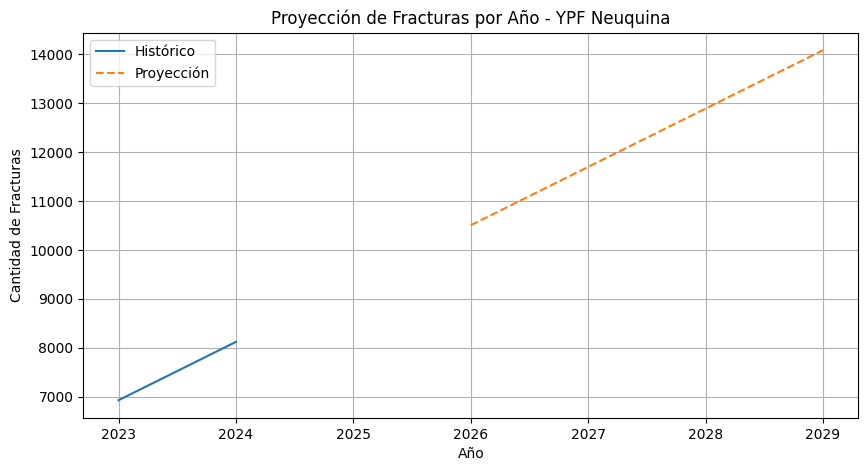

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv("/content/datosdefracturadepozos.zip")

# Filtrar datos
df_filtered = df[
    (df["empresa_informante"] == "YPF S.A.") &
    (df["cuenca"] == "NEUQUINA") &
    (df["anio"] >= 2023)
]

# Agrupar por año y calcular agregados
df_model = df_filtered[[
    "anio", "cantidad_fracturas",
    "arena_bombeada_nacional_tn",
    "longitud_rama_horizontal_m",
    "agua_inyectada_m3"
]]

df_aggregated = df_model.groupby("anio").agg({
    "cantidad_fracturas": "sum",
    "arena_bombeada_nacional_tn": "sum",
    "longitud_rama_horizontal_m": "mean",
    "agua_inyectada_m3": "sum"
}).reset_index()

# Entrenar modelo con años completos
train_data = df_aggregated[df_aggregated["anio"] < 2025]
X_train = train_data[[
    "arena_bombeada_nacional_tn",
    "longitud_rama_horizontal_m",
    "agua_inyectada_m3"
]]
y_train = train_data["cantidad_fracturas"]

model = LinearRegression()
model.fit(X_train, y_train)

# Extrapolar features hasta 2029
years_future = np.arange(2026, 2030)
years_existing = train_data["anio"].values.reshape(-1, 1)

def extrapolate(feature):
    lr = LinearRegression()
    lr.fit(years_existing, train_data[feature].values)
    return lr.predict(years_future.reshape(-1, 1))

arena_future = extrapolate("arena_bombeada_nacional_tn")
longitud_future = extrapolate("longitud_rama_horizontal_m")
agua_future = extrapolate("agua_inyectada_m3")

# Crear dataframe futuro
df_future = pd.DataFrame({
    "anio": years_future,
    "arena_bombeada_nacional_tn": arena_future,
    "longitud_rama_horizontal_m": longitud_future,
    "agua_inyectada_m3": agua_future
})

# Predecir fracturas
X_future = df_future[[
    "arena_bombeada_nacional_tn",
    "longitud_rama_horizontal_m",
    "agua_inyectada_m3"
]]
df_future["prediccion_fracturas"] = model.predict(X_future)

# Mostrar resultados
print(df_future[["anio", "prediccion_fracturas"]])

# Graficar
plt.figure(figsize=(10,5))
plt.plot(train_data["anio"], train_data["cantidad_fracturas"], label="Histórico")
plt.plot(df_future["anio"], df_future["prediccion_fracturas"], label="Proyección", linestyle="--")
plt.xlabel("Año")
plt.ylabel("Cantidad de Fracturas")
plt.title("Proyección de Fracturas por Año - YPF Neuquina")
plt.legend()
plt.grid(True)
plt.show()